## Loading the network

Reference:

- https://github.com/Verisig/verisig/tree/master/examples/mountain_car
- https://arxiv.org/abs/1811.01828

In [1]:
using Revise, NeuralNetworkAnalysis, NeuralVerification, YAML
const NV = NeuralVerification
const RA = ReachabilityAnalysis
const IA = IntervalArithmetic
const NNA = NeuralNetworkAnalysis

┌ Info: Precompiling NeuralNetworkAnalysis [73c0b437-a350-4e9b-97ac-9adb151c271b]
└ @ Base loading.jl:1278
┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{S}, Tuple{T}, Tuple{Array{TaylorModels.TaylorModel1{T,S},1},Type{var"#s14"} where var"#s14"<:Zonotope}} where S where T` in module `LazySets.Approximations`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{S}, Tuple{T}, Tuple{N}, Tuple{Array{TaylorModels.TaylorModelN{N,T,S},1},Type{var"#s12"} where var"#s12"<:Zonotope}} where S where T where N` in module `LazySets.Approximations`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{NM}, Tuple{N}, Tuple{LinearMap{N,var"#s8",NM,var"#s7"} where var"#s7"<:AbstractIntervalMatrix{NM} where var"#s8"<:AbstractZonotope{N},Type{var"#s6"} where var"#s6"<:Zonotope}} where NM where N<:Real` in module `LazySets.Approximations`
└ @

NeuralNetworkAnalysis

┌ Warning: Replacing docs for `LazySets.HPolytope :: Union{Tuple{Union{Polyhedra.HRepresentation{N}, Polyhedra.Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.HPolyhedron :: Union{Tuple{Union{Polyhedra.HRepresentation{N}, Polyhedra.Polyhedron{N}}}, Tuple{N}} where N` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{Union{HPolyhedron{N,VN} where VN<:AbstractArray{N,1}, HPolytope{N,VN} where VN<:AbstractArray{N,1}}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `Polyhedra.polyhedron :: Union{Tuple{VPolytope{N,VN} where VN<:AbstractArray{N,1}}, Tuple{N}} where N<:Real` in module `LazySets`
└ @ Base.Docs docs/Docs.jl:227


In [2]:
d = YAML.load_file("sig16x16.yml")
nnet = NNA.read_yaml(d);

## Computing the output using reachability

In [22]:
X0 = Hyperrectangle(low=[-0.6, 0], high=[-0.4, 0])
X0s = split(X0, [1, 1])
sol = [NNA.forward(nnet, X0) for X0 in X0s];

In [23]:
overapproximate(UnionSetArray(sol), Interval) # 8

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0.448458, -0.0581502])

In [24]:
overapproximate(UnionSetArray(sol), Interval) # 4

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0.448458, -0.0581502])

In [25]:
overapproximate(UnionSetArray(sol), Interval) # 1

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0.448458, -0.0581502])

## Computing the output with interval arithmetic

In [68]:
using NeuralNetworkAnalysis: Tanh, Sigmoid

function forward_IA(nnet, X0)
    X0dec = NNA._decompose_1D(X0)
    X = [X0i.dat for X0i in X0dec.array]

    for L in nnet.layers
        W = L.weights
        b = L.bias
        a = L.activation
        X′ = W * X + b
        if a == Tanh()
            X′ = @. tanh(X′)
        elseif a == Sigmoid()
            X′ = @. 1 / (1 + exp(-X′))
        elseif a == Id()
            nothing
        end
        X = copy(X′)
    end
    return X
end

forward_IA (generic function with 1 method)

In [69]:
X0 = Hyperrectangle(low=[-0.6, 0], high=[-0.4, 0])
y = forward_IA(nnet, X0) # gives [-0.739009, -0.578572] using X′ = W * X + b
# and also with X′ = IA.Interval.(W) * X + IA.Interval.(b)

1-element Array{IntervalArithmetic.Interval{Float64},1}:
 [-0.739009, -0.578572]

In [28]:
using Plots

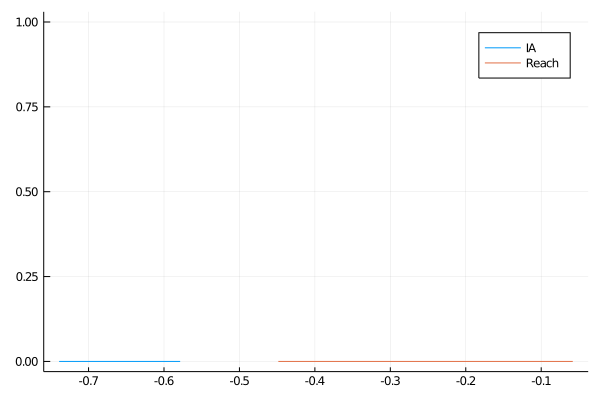

In [54]:
plot(Interval(y[1]), lab="IA")
r = overapproximate(UnionSetArray(sol), Interval) # 8
plot!(r, lab="Reach")

In [71]:
#NV.compute_output(nnet, center(X0))
using Distributions

B = convert(IntervalBox, X0)
NSAMPLES = 100
B1sample = rand(range(inf(B[1]), sup(B[1]), step=0.001), NSAMPLES)
B2sample = rand(range(inf(B[2]), sup(B[2]), step=0.001), NSAMPLES)

#convert(IntervalBox, NV.compute_output(nnet, center(X0)))
out = [NV.compute_output(nnet, [x, y])[1] for (x, y) in zip(B1sample, B2sample)];
z = overapproximate(UnionSetArray([Singleton([p]) for p in out]), Interval)

Interval{Float64,IntervalArithmetic.Interval{Float64}}([-0.739009, -0.582397])

In [74]:
argmax(out)
out[63]

-0.5823971870850192

In [75]:
B1sample[63]

-0.404

In [76]:
B2sample[63]

0.0

In [78]:
NV.compute_output(nnet, [-0.404, 0.0])

1-element Array{Float64,1}:
 -0.5823971870850192

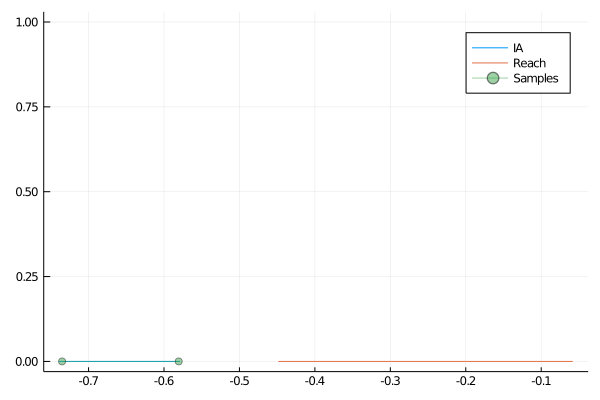

In [56]:
plot!(z × Singleton([0.0]) + Singleton([0.0, 0.00]), lab="Samples")

In [61]:
y[1] # forward computation using Interval Arithmetic

[-0.739009, -0.578572]

In [62]:
z.dat # forward computation using sampling

[-0.73507, -0.580487]

In [65]:
r.dat # forward using reachability

[-0.448458, -0.0581502]

Observations:

1) The interval with forward reach is disjoint with the others.

2) The interval with IA does not contain all samples.

## Discrete version

In [ ]:
function step(p, v, u)
    return (p + v, v + 0.0015u - 0.0025 * cos(3p))
end

In [ ]:
p, v = -0.4..0.6, 0. .. 0.

In [ ]:
function mountain_car(p, v, nnet; max_setps=150)
    reward = 100.
    n = 0
    for i=1:max_setps
        n += 1
        u = forward(nnet, Interval(p) × Interval(v))
        u = u.array[1].dat
        reward = reward - 0.1 * u^2
        p, v = step(p, v, u)
        if p.lo >= 0.45
            break
        end
    end
    return p, v, reward, n
end

In [ ]:
@time mountain_car(p, v, nnet)

## Continuous

In [ ]:
@taylorize function car!(dx, x, p, t)
    p, v, u = x
    dx[1] = p + v
    dx[2] = v + 0.0015u - 0.0025 * cos(3p)
    dx[3] = zero(u)

    return dx
end

X₀ = Hyperrectangle(low=[-0.41, 0], high=[-0.4, 0])
U₀ = Universe(1)
prob = @ivp(x' = car!(x), dim: 3, x(0) ∈ X₀ × U₀)
vars_idx = Dict(:state_vars=>1:2, :input_vars=>[], :control_vars=>[3]);

In [ ]:
plant = ControlledPlant(prob, nnet, vars_idx);
alg = TMJets(abs_tol=1e-9, orderT=8, orderQ=1)
solver = "hybrid"

@time sol = NNA.solve(plant, T=0.6, Tsample=0.2, alg_nn=solver, alg=alg)
#solz = overapproximate(sol, Zonotope);

In [ ]:
sol